# Rental List Classification
This is a Kaggle competition --[Two Sigma Connect: Rental Listing Inquiries](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries). The project aims to predict how much interest a new rental listing on RentHop will receive. The interest level of a list is determined based on the number of inquires a new listing receives and has been classified into 3 classes: High, Medium and Low. Features of the listints including the number of bedrooms, the number of bathrooms, listed price annd others are used to make the prediction.

## Part I: Data Explorary Analysis

In [3]:
# import the required modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ggplot import *
import seaborn as sns
from colour import Color
import re
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup 
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

### Read in the data set

In [2]:
# read in the training data set
train_set = pd.read_json(r'..\data\train.json')
test_set = pd.read_json(r'..\data\test.json')
print("Read in training data set with size of {} * {}".format(train_set.shape[0], train_set.shape[1]))
print("Read in testing data set with size of {} * {}".format(test_set.shape[0], test_set.shape[1]))

Read in training data set with size of 49352 * 15
Read in testing data set with size of 74659 * 14


In [56]:
# let's look at rhe dtype of each feature
for f in train_set.columns:
    print (f, ':', train_set[f].dtype)


bathrooms : float64
bedrooms : int64
building_id : object
created : object
description : object
display_address : object
features : object
interest_level : object
latitude : float64
listing_id : int64
longitude : float64
manager_id : object
photos : object
price : int64
street_address : object


In [13]:
train_set.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


#### Response variable: Interest Level

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64


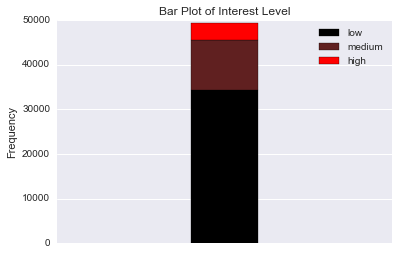

In [5]:
# Response var: interest_level
interest_level_count = train_set['interest_level'].value_counts()
print(interest_level_count)

# creaate gradient color bar for interest levels
red = Color("black")
level_c = list(red.range_to(Color("red"),len(interest_level_count)))


ax = plt.subplot(1, 1, 1)
for i in range(len(interest_level_count)): 
    ax.bar(0.2, interest_level_count[i], width=0.1, bottom=sum(interest_level_count[0:i]), label=interest_level_count.index[i], 
           color = level_c[i].rgb)
           
ax.set(xlim=(0, 0.5), xticks=(), title='Bar Plot of Interest Level', ylabel='Frequency')
plt.legend()
plt.show()


The majority of the listings are of low interest. The interest level is not balanced. Need to [deal with imbalanced data.](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

#### Features: Number of bedrooms, number of bathrooms

Descriptive stats of number of bedrooms: 

count    49352.000000
mean         1.541640
std          1.115018
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: bedrooms, dtype: float64

Descriptive stats of number of bathrooms: 

count    49352.00000
mean         1.21218
std          0.50142
min          0.00000
25%          1.00000
50%          1.00000
75%          1.00000
max         10.00000
Name: bathrooms, dtype: float64

Descriptive stats of bb_ratio: 

count    49352.000000
mean         0.799119
std          0.285335
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          5.000000
dtype: float64


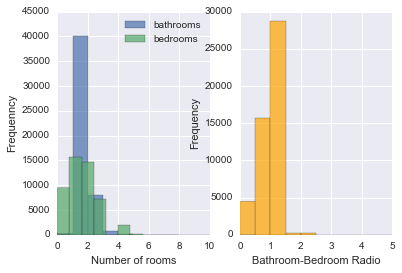

In [8]:
# Number of bedrooms, bathrooms
print("Descriptive stats of number of bedrooms: \n")
print(train_set['bedrooms'].describe())
print("\nDescriptive stats of number of bathrooms: \n")
print(train_set['bathrooms'].describe())

# create a new var: bathroom-bedroom ratio
# for those do not have a bedroom, assume they are studio and set the number of bedrooms to 1
bb_ratio = train_set['bathrooms'] / train_set['bedrooms'].apply(lambda x: x if x != 0 else 1)
print("\nDescriptive stats of bb_ratio: \n")
print(bb_ratio.describe())



for room in ('bathrooms', 'bedrooms'):
    ax = plt.subplot(1, 2, 1)
    train_set[room].hist(alpha=0.7, label=room)
ax.set(xlabel='Number of rooms', ylabel='Frequenncy')
ax.legend(loc=1)

ax = plt.subplot(1, 2, 2)
ax.hist(bb_ratio, color='orange', alpha=0.7)
ax.set(xlabel='Bathroom-Bedroom Radio', ylabel='Frequency')
plt.show()


In [23]:
print('There are {} listings with {} bathrooms'.format(train_set[train_set['bathrooms']==min(train_set['bathrooms'])].shape[0],
                                                      min(train_set['bathrooms'])))
print('There are {} listings with {} bathrooms'.format(train_set[train_set['bathrooms']==max(train_set['bathrooms'])].shape[0],
                                                      max(train_set['bathrooms'])))

train_set[train_set['bathrooms']==max(train_set['bathrooms'])]                                                      



There are 313 listings with 0.0 bathrooms
There are 1 listings with 10.0 bathrooms


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
104459,10,2,424f8014bddc288d26da5fe81d0bea02,2016-04-09 04:34:31,***The building?s well-attended lobby welcomes...,W 52 St.,"[Doorman, Elevator, Fitness Center, Laundry in...",low,40.7633,6849204,-73.9849,0c71a59cb70215fbf49c9dd93efaa172,[https://photos.renthop.com/2/6849204_1f92b58a...,3600,260 W 52 St.


The number of bedrooms is between 0 and 8 with an average of 1.54. The range is relatively reasonable, we can assume the listings with 0 bedrooms are studio. The number of bathrooms is between 0 and 10 with an average of 1.21. The majority of the lisings have 1 bathroom. There are 313 listings with no bathroom and 1 listing with 10 bathrooms but only 2 bedrooms. They may be some error entries or fraud cases.   
A new var bb_ratio is created to represent the ratio between the number of bathrooms and the number of bedrooms. For most of the listings, each bedroom has a bathroom of 

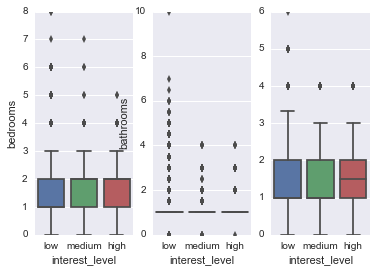

In [16]:
# Boxplots of number of bedroom, bathrooms and bb_ratio faceted by interest level
ax = plt.subplot(1, 3, 1)
sns.boxplot(x='interest_level', y='bedrooms', data=train_set, ax=ax, order=('low', 'medium', 'high'))
ax = plt.subplot(1, 3, 2)
sns.boxplot(x='interest_level', y='bathrooms', data=train_set, ax=ax, order=('low', 'medium', 'high'))
ax = plt.subplot(1, 3, 3)
sns.boxplot(x=train_set['interest_level'], y=bb_ratio, ax=ax,order=('low', 'medium', 'high'))
plt.show()


In [17]:
# longitute and latitude
print('Stats of the vars: longitude, latitude:')
print(train_set[['longitude', 'latitude']].describe())

# find potential outliers with longitude = 0
print('\nStats of latitude when longitude = 0:')
print(train_set[train_set['longitude']==0]['latitude'].describe())
print('\ninteset levels when longitude = 0:')
print(train_set[train_set['longitude']==0]['interest_level'].value_counts())



Stats of the vars: longitude, latitude:
          longitude      latitude
count  49352.000000  49352.000000
mean     -73.955716     40.741545
std        1.177912      0.638535
min     -118.271000      0.000000
25%      -73.991700     40.728300
50%      -73.977900     40.751800
75%      -73.954800     40.774300
max        0.000000     44.883500

Stats of latitude when longitude = 0:
count    12
mean      0
std       0
min       0
25%       0
50%       0
75%       0
max       0
Name: latitude, dtype: float64

inteset levels when longitude = 0:
low       11
medium     1
Name: interest_level, dtype: int64


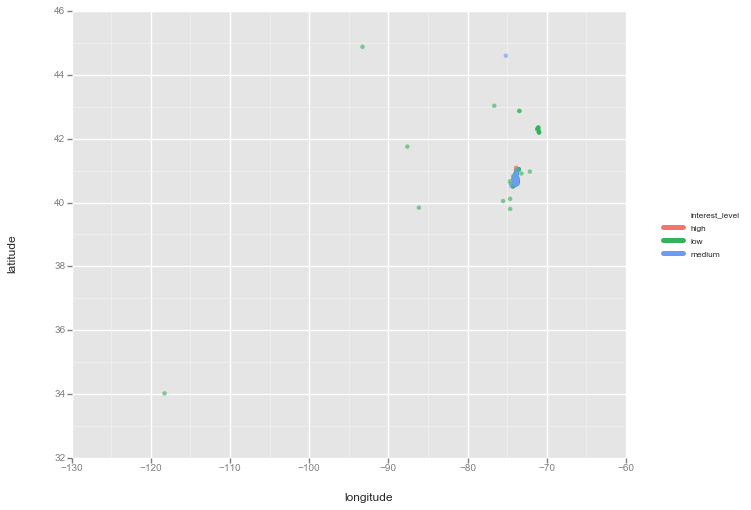

<ggplot: (-9223371921497794167)>


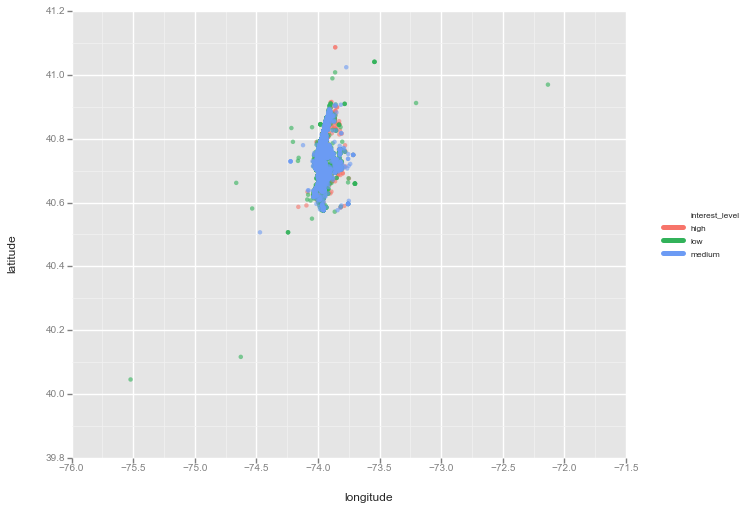

<ggplot: (115356981533)>


In [18]:
def zoomin_ll(data, condition):
    g = ggplot(data[condition], aes(x='longitude', y='latitude', color='interest_level')) + \
        geom_jitter(alpha=0.6)
    return g



# Let's zoom in (remove longitude = 0)
cond1 = train_set['longitude'] != 0
g1 = zoomin_ll(train_set, cond1)

# let's furthur zoom in (longtitude: 40~42, latitude: -80~-70)
cond2 = (train_set['latitude']<=42) & (train_set['latitude']>=40) & (train_set['longitude']>=-80) & (train_set['longitude']<=-70)
g2 = zoomin_ll(train_set, cond2)

print(g1)
print(g2)



In [19]:
# price
print('Stats of Price:')
print(train_set['price'].describe())
print('\nThe 10 cheapest prices are:')
print(sorted(train_set['price'])[:10])
print('\nThe 10 most expensive prices are:')
print(sorted(train_set['price'], reverse=True)[:10])



Stats of Price:
count      49352.000000
mean        3830.174036
std        22066.865885
min           43.000000
25%         2500.000000
50%         3150.000000
75%         4100.000000
max      4490000.000000
Name: price, dtype: float64

The 10 cheapest prices are:
[43, 45, 401, 695, 695, 695, 695, 700, 800, 868]

The 10 most expensive prices are:
[4490000, 1150000, 1070000, 1070000, 135000, 111111, 100000, 90000, 85000, 80000]


In [20]:
# use the Tukey Method to identify potential outliers in price
def turkey_outlier(data, var, alpha, outlier=True):
    q1 = np.percentile(data[var], 25)
    q3 = np.percentile(data[var], 75)
    if outlier:
        return data[(data[var] < (q1-alpha*(q3-q1)))], data[(data[var] > q3+alpha*(q3-q1))]
    else:
        return data[(data[var] >= (q1-alpha*(q3-q1))) & (data[var] <= q3+alpha*(q3-q1))]
price_lowoutliers, price_highoutliers = turkey_outlier(train_set, 'price', 1.5, True) # 2788 potential outliers
price_noout = turkey_outlier(train_set, 'price', 1.5, False)
print('There are {} low outliers and {} high outliers'.format(len(price_lowoutliers), len(price_highoutliers)))

print(price_lowoutliers['interest_level'].value_counts())
print(price_highoutliers['interest_level'].value_counts())

There are 2 low outliers and 2786 high outliers
low    2
Name: interest_level, dtype: int64
low       2572
medium     193
high        21
Name: interest_level, dtype: int64


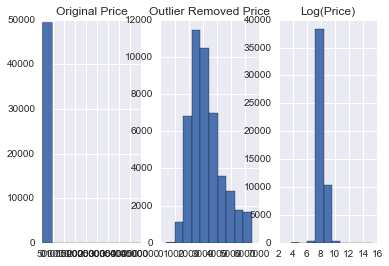

In [21]:
# hist of original price, outlier removed price and log(price)
ax = plt.subplot(1, 3, 1)
train_set['price'].hist()
ax.set(title='Original Price')
ax = plt.subplot(1, 3, 2)
price_noout['price'].hist()
ax.set(title='Outlier Removed Price')
ax = plt.subplot(1, 3, 3)
np.log(train_set['price']).hist()
ax.set(title='Log(Price)')
plt.show()


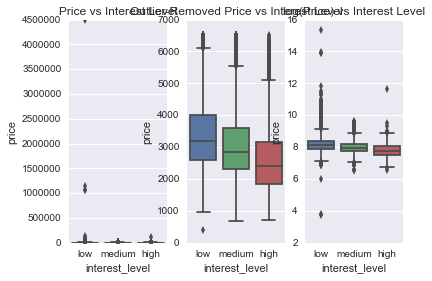

In [22]:
# price vs interest level
ax = plt.subplot(1, 3, 1)
sns.boxplot(x='interest_level', y='price', data=train_set, order=('low', 'medium', 'high'))
ax.set(title='Price vs Interest Level')
ax = plt.subplot(1, 3, 2)
sns.boxplot(x='interest_level', y='price', data=price_noout, order=('low', 'medium', 'high'))
ax.set(title='Outlier-Removed Price vs Interest Level')
ax = plt.subplot(1, 3, 3)
sns.boxplot(x=train_set['interest_level'], y=np.log(train_set['price']), order=('low', 'medium', 'high'))
ax.set(title='log(Price) vs Interest Level')
plt.show()

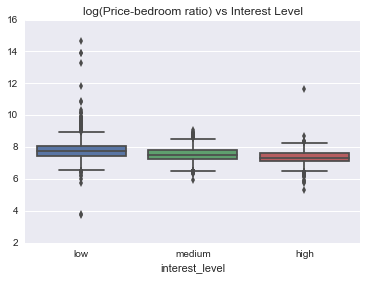

In [23]:
# price_bedroom ratio
price_bedroom_ratio = train_set['price']/train_set['bedrooms'].apply(lambda x: x if x !=0 else 1)
ax = plt.subplot(1, 1, 1)
sns.boxplot(x=train_set['interest_level'], y=np.log(price_bedroom_ratio), order=('low', 'medium', 'high'))
ax.set(title='log(Price-bedroom ratio) vs Interest Level')
plt.show()

In [24]:
# features
# number of features
num_features = train_set['features'].apply(len)
print('Stats of number of features:')
print(num_features.describe())

print('\nLongest Features:')
print(list(train_set['features'][train_set['features'].apply(len) == max(train_set['features'].apply(len))]))


Stats of number of features:
count    49352.000000
mean         5.428473
std          3.923411
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         39.000000
Name: features, dtype: float64

Longest Features:
[['Common Outdoor Space', 'Laundry In Unit', 'Cats Allowed', 'Private Outdoor Space', 'Dogs Allowed', 'Parking Space', 'Doorman', 'Elevator', 'Fitness Center', 'Laundry In Building', 'Concierge', 'Garage', 'Green Building', 'Health Club', 'High Speed Internet', 'Laundry', 'Lounge', 'New Construction', 'Roof Deck', 'Storage', 'Subway', 'Valet', 'Wheelchair Access', 'WiFi', 'Balcony', 'Dishwasher', 'Eat In Kitchen', 'Garden', 'Granite Kitchen', 'Hardwood', 'High Ceilings', 'Light', 'Live Work', 'Marble Bath', 'Outdoor Space', 'Patio', 'Renovated', 'Walk-In Closet', 'Walls OK']]


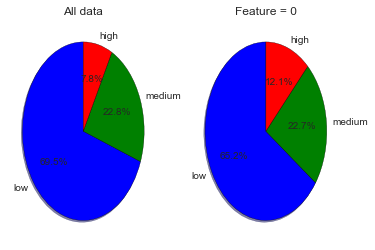

In [25]:
# let's look at those with 0 features
feature0_counts = train_set[train_set['features'].apply(len)==0]['interest_level'].value_counts()


ax1 = plt.subplot(1, 2, 1)
ax1.pie(interest_level_count, labels=interest_level_count.index, startangle=90, autopct='%1.1f%%', shadow=True)
ax1.set(title='All data')

ax2 = plt.subplot(1, 2, 2)
ax2.pie(feature0_counts, labels=feature0_counts.index, startangle=90, autopct='%1.1f%%', shadow=True)
ax2.set(title='Feature = 0')
plt.show()

In [26]:
# unique features
uniq_feat = set()
for f in train_set['features']:
    uniq_feat = uniq_feat.union(set(f))
print(len(uniq_feat))
list(uniq_feat)[:10]

1556


['A One-of-a-Kind Full service Luxury Highrise',
 'Leed Certificate Gold',
 'Convertible-2',
 'High Ceilings',
 'Luxury building',
 '1/2 bath',
 '81ST & CPW',
 'On-site Parking Lot',
 'Stainless Kitchen',
 'rooftop with grills']

In [27]:
# 1 feature
feature1 = train_set[train_set['features'].apply(len)==1]['features']
sorted(feature1, key=lambda x: len(x[0]), reverse=True)[:10]


[['** HEART OF THE VILLAGE! * MASSIVE 3BR SUPER SHARE * MR CLEAN APPROVED * ORNATE PREWAR DETAILS * GOURMET KITCHEN * TONS OF SUNLIGHT **'],
 ['** COURT SQUARE GEM! * SPRAWLING SUNDRENCHED 2BR HOME * CUSTOM FINISHES * DISHWASHER * FIREPLACES * EAT-IN KITCHEN * BAY WINDOWS **'],
 ['** ELEGANT E50s!! * SPRAWLING SUNDRENCHED 2BR HOME * FRENCH DRS * BREAKFAST BAR * DISHWASHER * EAT-IN KITCHEN * WALK-IN CLOSETS! **'],
 ['** THE PERFECT SHARE! * HUGE TRUE 3BR HOME * GOURMET KITCHEN * TONS OF NATURAL LIGHT * 2 BLKS TO WATERFRONT & BEDFORD L STOP **'],
 ['** SPRAWLING TRUE 3BR SUPER SHARE * FIT FOR KINGS! * UNIQUE RENOVATIONS * STEPS TO THE WATERFRONT * 1 BLK TO BEDFORD L STOP **'],
 ['** BROWNSTONE BEAUTY * MASSIVE 2BR HOME * STEPS TO THE PARK * SS KITCHEN * DISHWASHER * OVERSIZED CLOSETS * NEAR COLUMBIA U **'],
 ['** OVERSIZED & UNDERPRICED!! * SPRAWLING SUNFILLED STUDIO * GOURMET KITCHEN * GUT RENOVATED * W50s ~ NEAR CENTRAL PARK! **'],
 ['** W70s WINNER! * SUPER SWEET STUDIO * WALLS OF WIN

In [28]:
def feature_clean(feature_list):
    # some features are separated by '*' '.', '^' clean those features
    for ff in feature_list: 
        if any(x in ff for x in ('*', '.', '^')):
            feature_list.remove(ff)
            ff = re.sub('[*|^|.]+', ',', ff)
            # remove the ',' at the beginning and at the end of the string
            ff = re.sub('^[,]|[,]$', '', ff)
            feature_list += ff.split(',')
    # clean the text, strip and lower case
    return [f.strip().lower() for f in feature_list]

feature = train_set['features'].apply(feature_clean)

In [29]:
feature.head()
feature11 = feature[feature.apply(len)==1]
sorted(feature11, key=lambda x: len(x[0]), reverse=True)[:10]


[['offering  1 month free or 1 month op'],
 ['absolute value for size & location'],
 ['parking spot with additional fee'],
 ['wood-burning fireplace'],
 ['private outdoor space'],
 ['private outdoor space'],
 ['private outdoor space'],
 ['private outdoor space'],
 ['private outdoor space'],
 ['private outdoor space']]

In [30]:
train_set['features'] = feature


In [31]:
# All features
def get_features(feat):
    feature_list = []
    for f in feat:
        if f != []:
            feature_list += f
    return feature_list


feat = get_features(train_set['features'])


uniq_feat = set(feat)
print(len(uniq_feat))
list(uniq_feat)[:10]

#number of unique features from 1556 to 1464

1464


['gatehouse security',
 'dogs under 20 lbs',
 'stunning finishes',
 '3 bedroom',
 '1/2 bath',
 'sun deck',
 'hot water inc',
 'recently renovated',
 'parking ( additional fee)',
 'loft storage']

In [32]:
# feature frequency
def feat_freq(feat, n_feat=10, pect=True):
    '''Find feature frequency'''
    feature_list = get_features(feat)  
    feat_counts = collections.Counter(feature_list)
    if pect == True:
        num_feat = len(feature_list)
        for k, v in feat_counts.items():
            feat_counts[k] = v/num_feat            
    return sorted(feat_counts.items(), key = lambda x: x[1], reverse=True)[:n_feat]

feat_freq_all = feat_freq(train_set['features'])
feat_freq_l = feat_freq(train_set[train_set['interest_level']=='low']['features'])
feat_freq_m = feat_freq(train_set[train_set['interest_level']=='medium']['features'])
feat_freq_h = feat_freq(train_set[train_set['interest_level']=='high']['features'])
print(feat_freq_all)


[('elevator', 0.09780840378680426), ('hardwood floors', 0.0877010762535506), ('cats allowed', 0.08763406634725278), ('dogs allowed', 0.08203129362624108), ('doorman', 0.07806654083695373), ('dishwasher', 0.07750812495113861), ('laundry in building', 0.07052420360587751), ('no fee', 0.06731889642129872), ('fitness center', 0.04935651876091238), ('laundry in unit', 0.035124359217771024)]


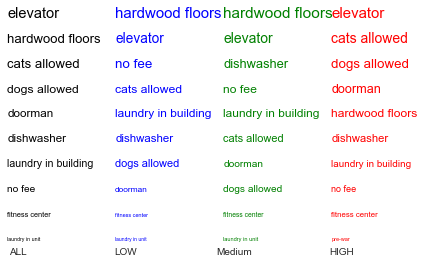

In [33]:
# plot the feature frequency
def plot_feat(feat_counts, ax, xtick, color):
    n_feat = len(feat_counts)
    ylim = np.linspace(n_feat*5, 5, n_feat)
    for i, (f, c) in enumerate(feat_counts):  
        ax.plot(xtick, ylim[i], 'g')
        ax.text(xtick, ylim[i], f, size=c*150, color=color)
    return ax

xtick_pos = (0, 20, 40, 60)
colors = ('black', 'blue', 'green', 'red')

ax = plt.subplot(1, 1, 1)
plot_feat(feat_freq_all, ax, xtick_pos[0], colors[0])
plot_feat(feat_freq_h, ax, xtick_pos[1], colors[1])
plot_feat(feat_freq_m, ax, xtick_pos[2], colors[2])
plot_feat(feat_freq_l, ax, xtick_pos[3], colors[3])

ax.grid(False)
ax.patch.set_facecolor('white')
ax.set_xticks(np.array(xtick_pos)+2)
ax.set_xticklabels(('ALL', 'LOW', 'Medium', 'HIGH'))
ax.yaxis.set_visible(False)
plt.show()

# we can see that the top words seem to be similar



In [34]:
# description
description = train_set['description'].iloc[0:3]
print(type(description))

# print some descriptions
print('Description Example: ')
print(description.iloc[0])

print('\nThe longest description:')
print(description[description.apply(len)==max(description.apply(len))].iloc[0])




<class 'pandas.core.series.Series'>
Description Example: 
A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a  website_redacted 

The longest description:
Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Building is very well maintained and 

In [35]:
# define a stemmer
stemmer = SnowballStemmer("english")


# preprocessor function
def preprocessor(text, stemmer):
    # remove numbers
    text = re.sub('[0-9]*', '', text)
    # lowercase
    # text = text.lower()
    # lowecase is included in the stem process
    
    # other preprocessing, such as remove HTML tags, strip    
    # also needs to steam
    text = ' '.join([stemmer.stem(x) for x in text.split()])
    return text


des_try = train_set.iloc[0:3]['description']

cv_vectorizer = CountVectorizer(min_df=2, stop_words='english', ngram_range=(1, 2), preprocessor=lambda p: preprocessor(p, stemmer=stemmer))
descrip_cv = cv_vectorizer.fit_transform(des_try)
descrip_cv = descrip_cv.toarray()
print(descrip_cv)
print(cv_vectorizer.get_feature_names())



[[ 2  1  1  1  6  3  1  1  1  1  1  1  2  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  1  1 10  7  2  1  1  1  1  1  1  1]]
['apart', 'apart featur', 'bathroom', 'bedroom', 'br', 'br br', 'featur', 'granit', 'hardwood', 'kitchen', 'new', 'real', 'room', 'website_redact']


In [36]:
# reference: http://www.akbarian.org/notes/text-mining-nlp-python/
# TF-IDF
tf_vectorizer = TfidfVectorizer(min_df=2, stop_words='english', ngram_range=(1, 2), preprocessor=lambda p: preprocessor(p, stemmer=stemmer))

descrip_tf = tf_vectorizer.fit_transform(des_try)

descrip_tf = descrip_tf.toarray()
print(descrip_tf)
print(tf_vectorizer.get_feature_names())




[[ 0.25197632  0.12598816  0.12598816  0.12598816  0.75592895  0.37796447
   0.12598816  0.12598816  0.12598816  0.12598816  0.12598816  0.12598816
   0.25197632  0.12598816]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.15476465  0.07738232  0.07738232  0.07738232  0.77382323  0.54167626
   0.15476465  0.07738232  0.07738232  0.07738232  0.07738232  0.07738232
   0.07738232  0.07738232]]
['apart', 'apart featur', 'bathroom', 'bedroom', 'br', 'br br', 'featur', 'granit', 'hardwood', 'kitchen', 'new', 'real', 'room', 'website_redact']


count    49352.000000
mean         5.606946
std          3.632283
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         68.000000
Name: photos, dtype: float64


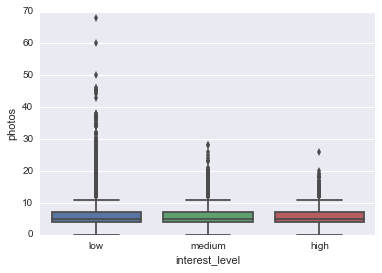

In [37]:
# photo: a list of 
photo_count = train_set['photos'].apply(len)

print(photo_count.describe())


sns.boxplot(x=train_set['interest_level'], y=photo_count, order=('low', 'medium', 'high'))
plt.show()


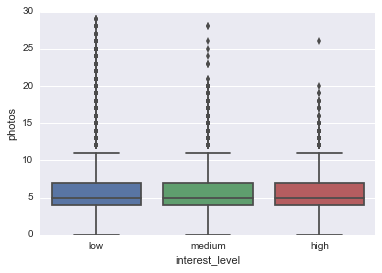

In [38]:
# for number of photos < 30
sns.boxplot(x=train_set[photo_count<30]['interest_level'], y=photo_count[photo_count<30], order=('low', 'medium', 'high'))
plt.show()



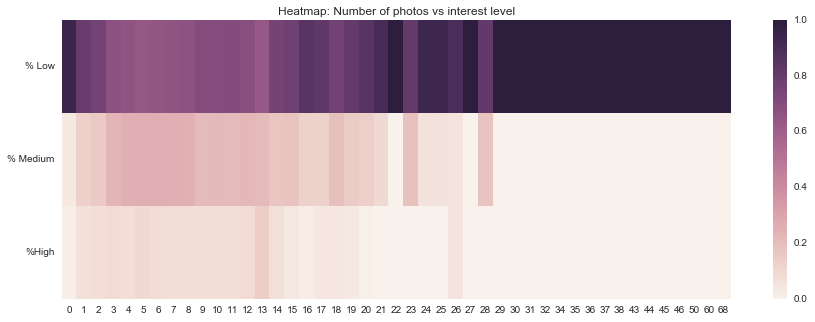

In [39]:
# draw a heatmap

def interest_level_dist(data, catgorical_var):
    interest_level_copy = data['interest_level'].copy()
    pd_dist = pd.DataFrame(columns=('pct_l', 'pct_m', 'pct_h'))   
    var_levels = sorted(np.unique(catgorical_var))
    for c in var_levels:
        temp_data = interest_level_copy[catgorical_var == c]
        pct_l = sum(temp_data == 'low') / temp_data.shape[0]
        pct_m = sum(temp_data == 'medium') / temp_data.shape[0]
        pct_h = 1 - pct_l - pct_m
        temp = pd.Series([pct_l, pct_m, pct_h], index=('pct_l', 'pct_m', 'pct_h'))
        pd_dist = pd_dist.append(temp, ignore_index=True)
        interest_level_copy = interest_level_copy[catgorical_var != c]
    pd_dist.index = var_levels
    return pd_dist
    
pd_photocount = interest_level_dist(train_set, photo_count).transpose()
plt.figure(figsize=(15,5))
sns.heatmap(pd_photocount, vmin=0, vmax=1, yticklabels=('% Low', '% Medium', '%High'))
plt.title('Heatmap: Number of photos vs interest level')
plt.yticks(rotation=0)
plt.show()


In [40]:
# manager_id
print ('There are {} managers'.format(len(train_set['manager_id'].unique())))

# how many posts
manager_counts = train_set['manager_id'].value_counts()

print(manager_counts.describe())
# the most 2533 houses

# let's check the manager with 2533 houses
train_set[train_set['manager_id'] == manager_counts.idxmax()]['interest_level'].value_counts()
# average level



There are 3481 managers
count    3481.000000
mean       14.177535
std        53.045270
min         1.000000
25%         1.000000
50%         4.000000
75%        13.000000
max      2533.000000
Name: manager_id, dtype: float64


low       1739
medium     622
high       172
Name: interest_level, dtype: int64

In [41]:
# create a new var: number of lists the manager has
# make manager_counts into a data frame, then merge to train_set
manager_counts_df = manager_counts.to_frame(name='manager_counts')
train_set_add_manager = train_set.merge(manager_counts_df, 'inner', left_on='manager_id', right_index=True)
train_set_add_manager.tail()




,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,manager_counts
99093,1.0,1,0,2016-04-17 01:33:08,Nice size high floor king size full 1 bedroomG...,East 39th Street,"[doorman, fitness center, pre-war, dogs allowe...",low,40.7489,6885503,-73.9765,583000f7853e1dff94bdf9433d5afa45,[https://photos.renthop.com/2/6885503_02685c3b...,3350,150 East 39th Street,1
99360,1.0,1,0,2016-04-19 05:22:03,Welcome to this Queen Size Two Bedroom in Hami...,136th St.,"[dogs allowed, cats allowed]",low,40.8214,6895018,-73.9563,d6956eb881462215a4fc348ee7d70891,[https://photos.renthop.com/2/6895018_2a37bb1e...,2300,636 136th St.,1
99745,1.0,2,bff1a7374bd3c233e37e1ff40ef3c690,2016-04-14 12:44:05,"Absolutely stunning, extremely large 2 bedroom...",Bay Ridge Parkway,"[laundry in unit, cats allowed, private outdoo...",medium,40.6211,6874060,-74.0093,5fb43ae7b345a0f81093fd95ced23031,[https://photos.renthop.com/2/6874060_26476dac...,2195,1220 Bay Ridge Parkway,1
998,1.5,1,9f136f839101eaec2e89e711a182593b,2016-06-11 03:15:03,Be a part of the select few in residence at th...,1 Main Street,"[doorman, elevator, cats allowed, dogs allowed]",low,40.7035,7140186,-73.9902,916668a9ae4b9a3eeb2356c0c15d0384,[https://photos.renthop.com/2/7140186_61a01ab0...,4995,1 Main Street,1
99803,1.0,1,967334d616535908b981faf575371ecb,2016-04-19 02:24:06,253 East 10th Street is an Miron Properties Ex...,East 10th Street,"[roof deck, laundry in unit, green building, d...",medium,40.7287,6892182,-73.9837,8ceaf83d7371a6c901362d7e7da9805e,[https://photos.renthop.com/2/6892182_f859d3d7...,3641,253 East 10th Street,1


In [42]:
# are there any very good or very bad manager, restrict to those managers with >= 4 
manager_gt4_data = train_set[train_set['manager_id'].isin(manager_counts[manager_counts>=4].index.values)]

manager_interest_level = interest_level_dist(manager_gt4_data, manager_gt4_data['manager_id'])


In [43]:
good_managers = manager_interest_level[manager_interest_level['pct_h']>0.5]
bad_managers = manager_interest_level[manager_interest_level['pct_l']>0.8]

print("There are {} good managers".format(good_managers.shape[0]))
print("There are {} bad managers".format(bad_managers.shape[0]))


There are 37 good managers
There are 825 bad managers


In [44]:
# time: year, month, hour
def process_date(date):
    '''Returns the year, month and hour of the date'''
    year = date[:4]
    month = date[5:7]
    hour = date[11:13]
    return pd.Series([year, month, hour], index=('year', 'month', 'hour'))

df_date = train_set['created'].apply(process_date)





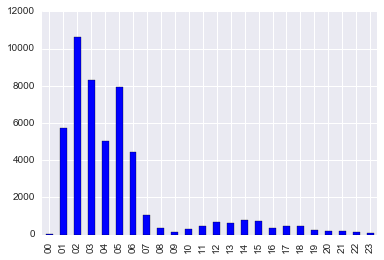

In [45]:
df_date['year'].unique() # all in 2016
df_date['month'].value_counts() # month in 4, 5, 6
df_date['hour'].value_counts().sort_index().plot(kind='bar') # most posts created between 1 am to 6 am


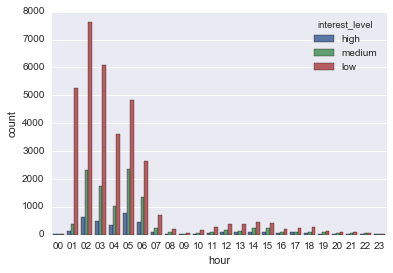

In [46]:
# hour vs interest_level
sns.countplot(x=df_date['hour'], hue=train_set['interest_level'], hue_order=('high', 'medium', 'low'))
# for all the hours, low > medium > high
# 6am seems to perform the best




In [65]:
# street address and display address
synonyms = [(r'([\d])((st)|(nd)|(rd)|(th))', r'\1'),(r'( street)|( st)', r' st.'), (r'( avenue)|( ave)', r' ave.'), 
            (r'(w )', r'west '),(r'(e )', r'east '), (r'(n )', r'north '), (r'(s )', r'south ')]

def process_address(address, synonyms):
    '''Clean the address vars.
    '''
    address = address.lower()
    address = address.strip()
    for s1, s2 in synonyms:
        address = re.sub(s1, s2, address)
    return address

display_ad = train_set['display_address'].apply(lambda x: process_address(x, synonyms))
street_ad = train_set['street_address'].apply(lambda x: process_address(x, synonyms))
print(display_ad.head())

print(street_ad.head())

10        metropolitanorth ave.
10000         columbusouth ave.
100004              west 13 st.
100007              east 49 st.
100013             west 143 st.
Name: display_address, dtype: object
10        792 metropolitanorth ave.
10000         808 columbusouth ave.
100004              241 west 13 st.
100007              333 east 49 st.
100013             500 west 143 st.
Name: street_address, dtype: object


In [48]:
# depulated street address
st_counts = street_ad.value_counts()
len(st_counts[st_counts > 1]) # 6282 street address with more than 2

big_address = st_counts[st_counts > 100]
big_address.head()

3333 broadway        175
505 west 37  st.     169
200 water st.        164
90 washington st.    147
100 maiden lane      140
Name: street_address, dtype: int64

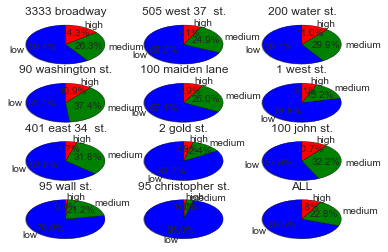

In [49]:
# let's look at the big address
for i, index in enumerate(big_address.index.values):
    df_temp = train_set[street_ad == index]['interest_level'].value_counts()
    ax1 = plt.subplot(4, 3, (i+1))
    ax1.pie(df_temp, labels=df_temp.index, startangle=90, autopct='%1.1f%%', shadow=True)
    ax1.set(title=index)
    
ax1 = plt.subplot(4, 3, 12)
ax1.pie(train_set['interest_level'].value_counts(), labels=train_set['interest_level'].value_counts().index, startangle=90, autopct='%1.1f%%', shadow=True)
ax1.set(title='ALL')

plt.show()

# 3333 broadway, 200 water st and 90 washington st doing well
# 95 christopher st not good


C:\Users\Anqi\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anqi\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(49350, 6)
(39422, 6)
(39389, 6)
(39388, 6)
(39256, 6)


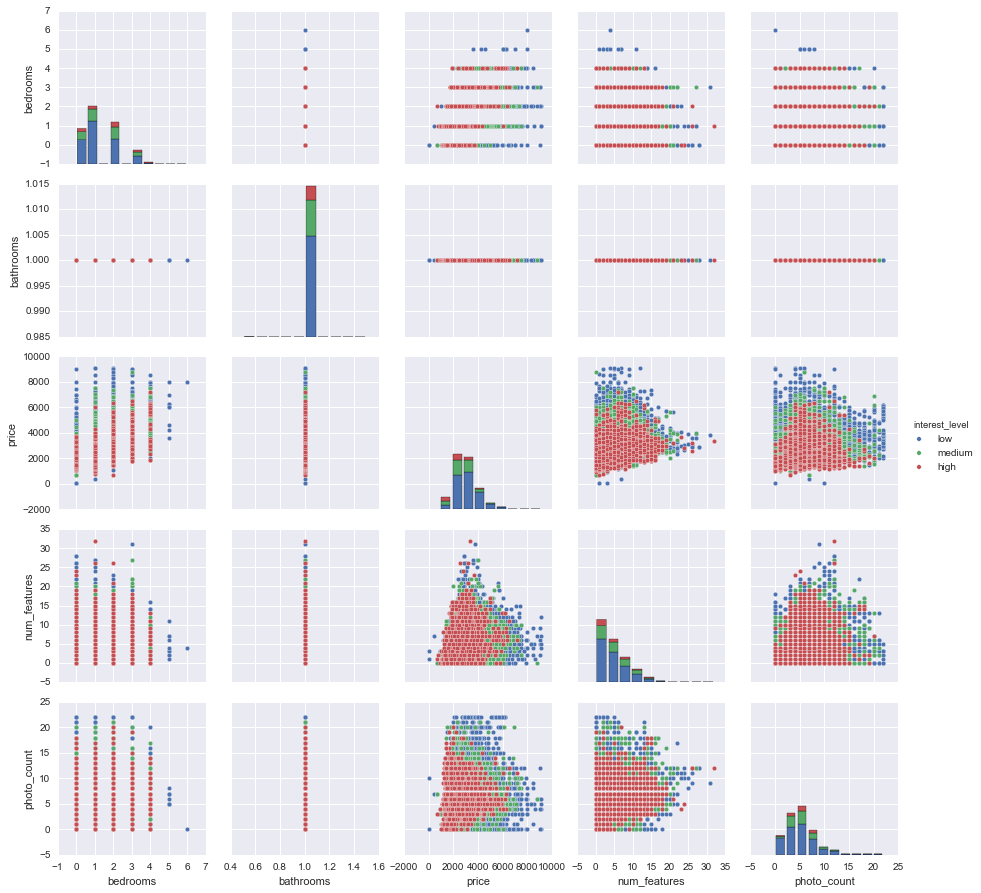

In [81]:
# bi cor between continuous var pairs 
# numeric vars: bedrooms, bathrooms, price, num_features, photo_count

train_set_numeric=train_set[['bedrooms', 'bathrooms', 'price', 'interest_level']]
train_set_numeric['num_features'] = num_features
train_set_numeric['photo_count'] = photo_count

# for each of the numeric var, remove outliers to better show the relation
for col in train_set_numeric.columns: 
    if train_set_numeric[col].dtype != object:
        train_set_numeric = turkey_outlier(train_set_numeric, col, 5, outlier=False)
        print(train_set_numeric.shape)
        

sns.pairplot(train_set_numeric, hue="interest_level", hue_order=('low', 'medium', 'high'))


In [ ]:
features_to_use =[]

bathrooms : float64
bedrooms : int64
building_id : object
created : object
description : object
display_address : object
features : object
interest_level : object
latitude : float64
listing_id : int64
longitude : float64
manager_id : object
photos : object
price : int64
street_address : object
